In [47]:
import warnings
from sklearn.exceptions import ConvergenceWarning
warnings.filterwarnings("ignore", category=ConvergenceWarning)
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=UserWarning)

import itertools
import numpy as np
import pandas as pd
import os
import matplotlib.pyplot as plt
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from PIL import Image
from sklearn.metrics import classification_report, f1_score , confusion_matrix



# Tensorflow Libraries
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import *
from tensorflow.keras.preprocessing.image import ImageDataGenerator




mixed_precision.set_global_policy('mixed_float16')


print(tf.__version__)

2.15.0


# Loading Dataset

In [48]:
# !unzip preprocessed_birds

In [49]:
path = "preprocessed_birds"


data = {"imgpath": [] , "labels": [] }

category = os.listdir(path)
for folder in category:
    folderpath = os.path.join(path , folder)
    filelist = os.listdir(folderpath)
    for file in filelist:
        fpath = os.path.join(folderpath, file)
        data["imgpath"].append(fpath)
        data["labels"].append(folder)


df = pd.DataFrame(data)

#Convert labels to numbers
lb = LabelEncoder()
df['encoded_labels'] = lb.fit_transform(df['labels'])

In [50]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Split the Dataset into Train & Test

In [51]:
train_df, Temp_df = train_test_split(df,  train_size= 0.70 , shuffle=True, random_state=124)
valid_df , test_df = train_test_split(Temp_df ,  train_size= 0.70 , shuffle=True, random_state=124)
train_df = train_df.reset_index(drop=True)
valid_df = valid_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

print("----------Train-------------")
print(train_df[["imgpath", "labels"]].head(5))
print(train_df.shape)
print("--------Validation----------")
print(valid_df[["imgpath", "labels"]].head(5))
print(valid_df.shape)
print("----------Test--------------")
print(test_df[["imgpath", "labels"]].head(5))
print(test_df.shape)

----------Train-------------
                                      imgpath    labels
0  preprocessed_birds/flamingo/7afc600754.jpg  flamingo
1    preprocessed_birds/parrot/080a286cf3.jpg    parrot
2  preprocessed_birds/flamingo/9c1031b4dc.jpg  flamingo
3      preprocessed_birds/crow/484d3397a2.jpg      crow
4     preprocessed_birds/eagle/26f6dfabaf.jpg     eagle
(503, 3)
--------Validation----------
                                        imgpath      labels
0     preprocessed_birds/penguin/55b7ad48b2.jpg     penguin
1        preprocessed_birds/duck/3e12e9e793.jpg        duck
2         preprocessed_birds/owl/8ee28cd014.jpg         owl
3  preprocessed_birds/woodpecker/5ec833f7bf.jpg  woodpecker
4       preprocessed_birds/goose/7bf59080b4.jpg       goose
(151, 3)
----------Test--------------
                                    imgpath  labels
0   preprocessed_birds/goose/36ebca7932.jpg   goose
1  preprocessed_birds/pigeon/4f365b6a6e.jpg  pigeon
2     preprocessed_birds/owl/556a08fbfa.jpg

# Show sample from data

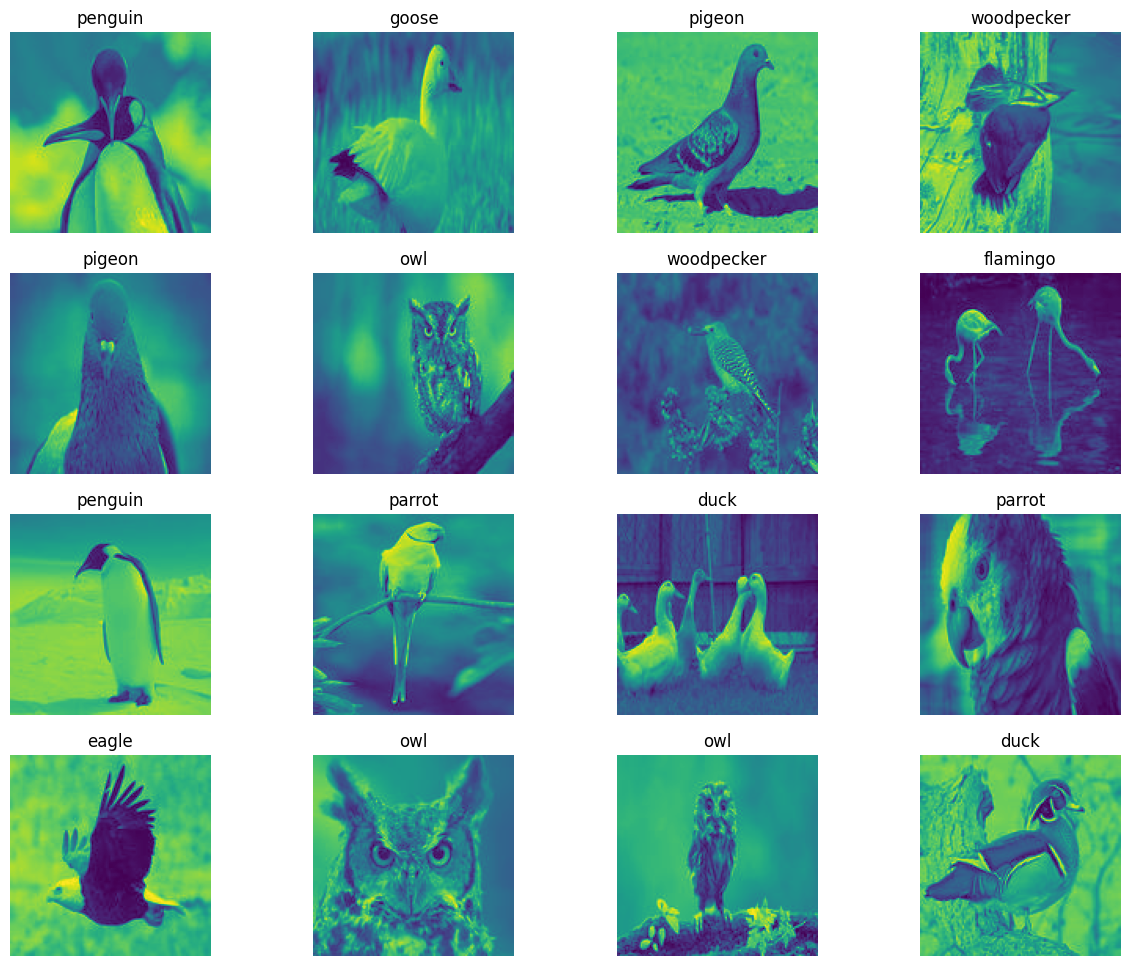

In [52]:
plt.figure(figsize=(15,12))
for i, row in test_df.sample(n=16).reset_index().iterrows():
    plt.subplot(4,4,i+1)
    image_path = row['imgpath']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(row["labels"])
    plt.axis('off')
plt.show()

# Creating Dataloaders

In [53]:
%%time

BATCH_SIZE = 15
IMAGE_SIZE = (128, 128)


generator = ImageDataGenerator(
    preprocessing_function = tf.keras.applications.efficientnet.preprocess_input,
    # there could be image augmentation here
)

# Split the data into three categories.
train_images = generator.flow_from_dataframe(
    dataframe=train_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=True,
    seed=42,
)

val_images = generator.flow_from_dataframe(
    dataframe=valid_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

test_images = generator.flow_from_dataframe(
    dataframe=test_df,
    x_col='imgpath',
    y_col='labels',
    target_size=IMAGE_SIZE,
    color_mode='rgb',
    class_mode='categorical',
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 503 validated image filenames belonging to 12 classes.
Found 151 validated image filenames belonging to 12 classes.
Found 66 validated image filenames belonging to 12 classes.
CPU times: user 27 ms, sys: 2.98 ms, total: 30 ms
Wall time: 30.2 ms


In [54]:
train_images.samples

503

In [55]:
# Load the pretained model
pretrained_model = tf.keras.applications.EfficientNetB3(
    input_shape=(128, 128, 3),
    include_top=False, # we don`t need a pre-trained top layer (output layer)
    weights='imagenet',
    pooling='max'
)

# Freezing the layers of a pretrained neural network
for i, layer in enumerate(pretrained_model.layers):
    pretrained_model.layers[i].trainable = False

# Model Structure

In [58]:
num_classes = len(set(train_images.classes))

from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model

# # Data Augmentation Step
# augment = tf.keras.Sequential([
#   layers.experimental.preprocessing.RandomFlip("horizontal"),
#   layers.experimental.preprocessing.RandomRotation(0.15),
#   layers.experimental.preprocessing.RandomZoom(0.15),
#   layers.experimental.preprocessing.RandomContrast(0.15),
# ], name='AugmentationLayer')



inputs = layers.Input(shape = (128,128,1), name='inputLayer')
x = inputs
pretrain_out = pretrained_model(x, training = False)
x = layers.Dense(256)(pretrain_out)
x = layers.Activation(activation="relu")(x)
x = BatchNormalization()(x)
x = layers.Dropout(0.45)(x)
x = layers.Dense(num_classes)(x)
outputs = layers.Activation(activation="softmax", dtype=tf.float32, name='activationLayer')(x) # mixed_precision need separated Dense and Activation layers
model = Model(inputs=inputs, outputs=outputs)



model.compile(
    optimizer=Adam(0.0005),
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 128, 128, 1)]     0         
                                                                 
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense_11 (Dense)            (None, 256)               393472    
                                                                 
 activation_5 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dropout_5 (Dropout)         (None, 256)               0   

# Training : Transfer Learning

In [59]:
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau

# tf.config.list_physical_devices('GPU')

history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=10,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 10 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

Epoch 1/10
34/34 [==============================] - 174s 5s/step - loss: 2.0353 - accuracy: 0.3996 - val_loss: 1.2113 - val_accuracy: 0.6623 - lr: 5.0000e-04
Epoch 2/10
34/34 [==============================] - 152s 5s/step - loss: 0.6594 - accuracy: 0.7873 - val_loss: 0.7708 - val_accuracy: 0.7417 - lr: 5.0000e-04
Epoch 3/10
34/34 [==============================] - 157s 5s/step - loss: 0.3896 - accuracy: 0.8728 - val_loss: 0.7072 - val_accuracy: 0.7881 - lr: 5.0000e-04
Epoch 4/10
34/34 [==============================] - 150s 4s/step - loss: 0.2401 - accuracy: 0.9384 - val_loss: 0.7237 - val_accuracy: 0.7748 - lr: 5.0000e-04
Epoch 5/10
34/34 [==============================] - 152s 5s/step - loss: 0.1463 - accuracy: 0.9781 - val_loss: 0.7075 - val_accuracy: 0.7881 - lr: 5.0000e-04
Epoch 6/10
34/34 [==============================] - 152s 5s/step - loss: 0.1330 - accuracy: 0.9781 - val_loss: 0.6953 - val_accuracy: 0.7947 - lr: 1.0000e-04
Epoch 7/10
34/34 [==============================] - 

# Display model performance

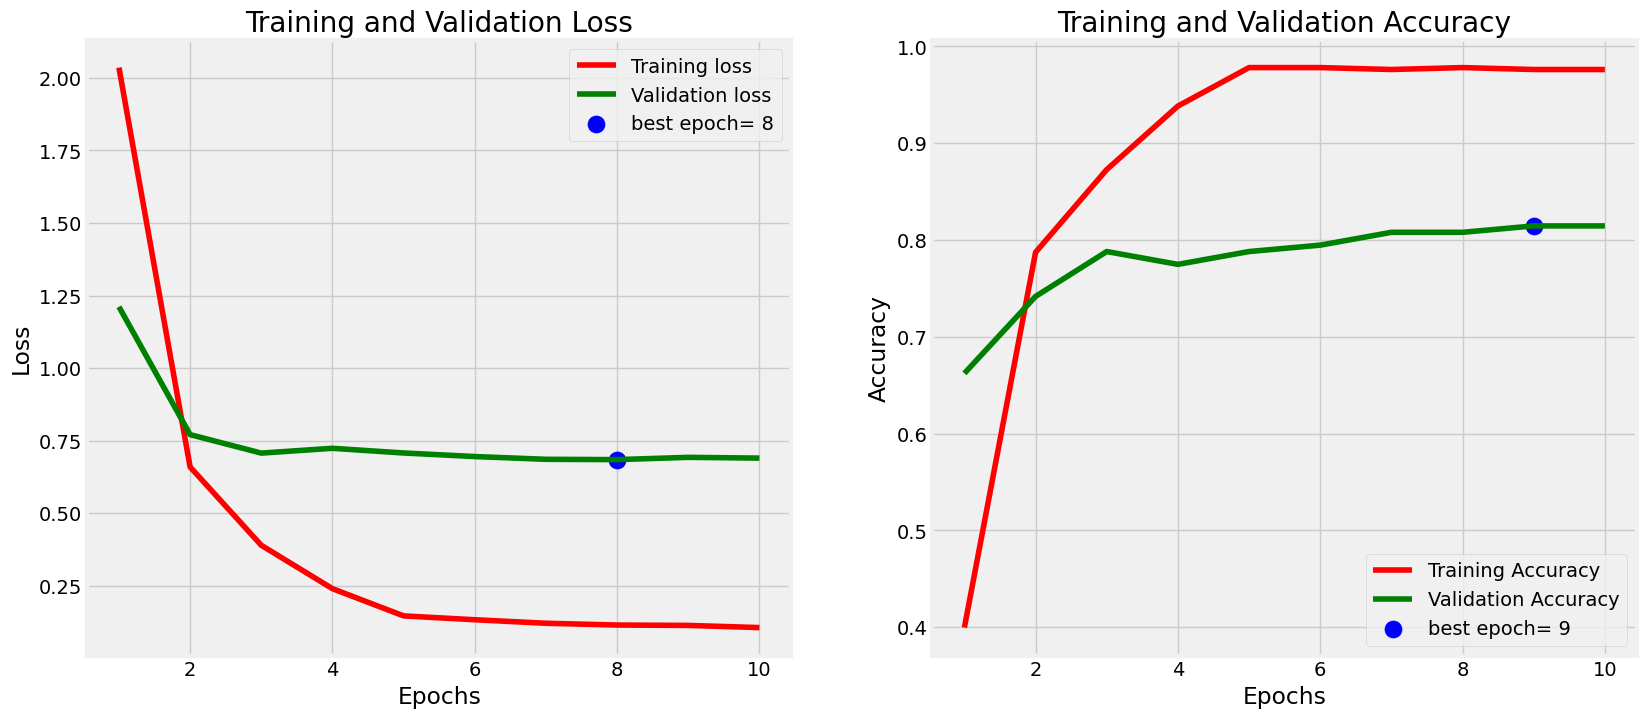

In [60]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# Training : Fine Tuning

In [61]:
pretrained_model.trainable = True
for layer in pretrained_model.layers:
    if isinstance(layer, layers.BatchNormalization): # set BatchNorm layers as not trainable
        layer.trainable = False

# let`s see first 10 layers
for l in pretrained_model.layers[:10]:
    print(l.name, l.trainable)

model.compile(
    optimizer=Adam(0.00001), # fine tuning requires very little learning rate
    loss='categorical_crossentropy',
    metrics=['accuracy']
)
# model.load_weights('./checkpoints/my_checkpoint')
print(model.summary())
history = model.fit(
    train_images,
    steps_per_epoch=len(train_images),
    validation_data=val_images,
    validation_steps=len(val_images),
    epochs=15,
    callbacks=[
        EarlyStopping(monitor = "val_loss", # watch the val loss metric
                               patience = 3,
                               restore_best_weights = True), # if val loss decreases for 5 epochs in a row, stop training,
        ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=2, mode='min')
    ]
)
model.save_weights('./checkpoints/my_checkpoint')

input_2 True
rescaling_2 True
normalization_1 True
rescaling_3 True
stem_conv_pad True
stem_conv True
stem_bn False
stem_activation True
block1a_dwconv True
block1a_bn False
Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputLayer (InputLayer)     [(None, 128, 128, 1)]     0         
                                                                 
 efficientnetb3 (Functional  (None, 1536)              10783535  
 )                                                               
                                                                 
 dense_11 (Dense)            (None, 256)               393472    
                                                                 
 activation_5 (Activation)   (None, 256)               0         
                                                                 
 batch_normalization_5 (Bat  (None, 256)               1024      
 chNormalization)

KeyboardInterrupt: 

# Display model performance

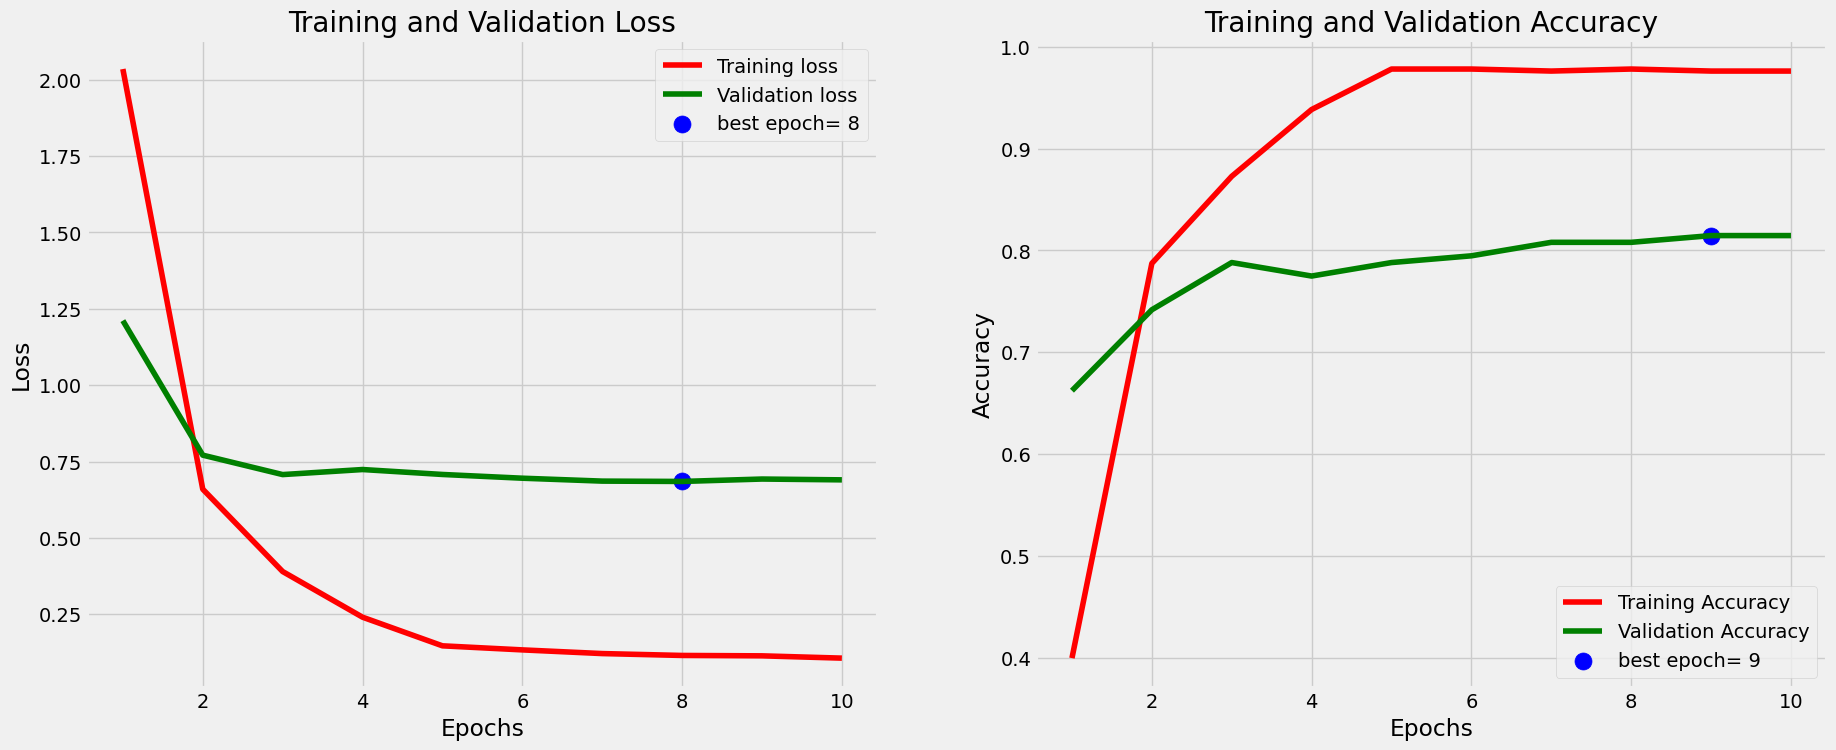

In [62]:
# Define needed variables
tr_acc = history.history['accuracy']
tr_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
index_loss = np.argmin(val_loss)
val_lowest = val_loss[index_loss]
index_acc = np.argmax(val_acc)
acc_highest = val_acc[index_acc]
Epochs = [i+1 for i in range(len(tr_acc))]
loss_label = f'best epoch= {str(index_loss + 1)}'
acc_label = f'best epoch= {str(index_acc + 1)}'

# Plot training history
plt.figure(figsize= (20, 8))
plt.style.use('fivethirtyeight')

plt.subplot(1, 2, 1)
plt.plot(Epochs, tr_loss, 'r', label= 'Training loss')
plt.plot(Epochs, val_loss, 'g', label= 'Validation loss')
plt.scatter(index_loss + 1, val_lowest, s= 150, c= 'blue', label= loss_label)
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(Epochs, tr_acc, 'r', label= 'Training Accuracy')
plt.plot(Epochs, val_acc, 'g', label= 'Validation Accuracy')
plt.scatter(index_acc + 1 , acc_highest, s= 150, c= 'blue', label= acc_label)
plt.title('Training and Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()

plt.tight_layout
plt.show()

# model.evaluate

In [63]:
results = model.evaluate(test_images, verbose=0)

print("    Test Loss: {:.5f}".format(results[0]))
print("Test Accuracy: {:.2f}%".format(results[1] * 100))

    Test Loss: 0.50427
Test Accuracy: 84.85%


# F1 Score / Recall / Precision

In [64]:
y_true = test_images.classes
y_pred = np.argmax(model.predict(test_images), axis = 1)
f1 = f1_score(y_true, y_pred, average='macro')
print("F1 Score:", f1)
print(classification_report(y_true, y_pred, target_names=test_images.class_indices.keys()))

5/5 [==============================] - 28s 3s/step
F1 Score: 0.8301139492315963
                precision    recall  f1-score   support

          crow       0.67      0.67      0.67         3
          duck       1.00      0.75      0.86         4
         eagle       1.00      0.86      0.92         7
      flamingo       1.00      0.89      0.94         9
         goose       0.80      0.80      0.80         5
           owl       0.80      0.80      0.80         5
        parrot       0.57      1.00      0.73         4
pelecaniformes       1.00      1.00      1.00         7
       penguin       0.83      0.83      0.83         6
        pigeon       1.00      0.50      0.67         6
        turkey       0.75      1.00      0.86         6
    woodpecker       0.80      1.00      0.89         4

      accuracy                           0.85        66
     macro avg       0.85      0.84      0.83        66
  weighted avg       0.88      0.85      0.85        66



# Get Predictions

In [65]:
classes = dict(zip(test_images.class_indices.values(), test_images.class_indices.keys()))
Predictions = pd.DataFrame({"Image Index" : list(range(len(test_images.labels))),
                            "Test Labels" : test_images.labels,
                            "Test Classes" : [classes[i] for i in test_images.labels],
                            "Prediction Labels" : y_pred,
                            "Prediction Classes" : [classes[i] for i in y_pred],
                            "Path": test_images.filenames,
                            "Prediction Probability" : [x for x in np.asarray(tf.reduce_max(model.predict(test_images), axis = 1))]
                           })
Predictions.head(8)

5/5 [==============================] - 20s 4s/step


,Image Index,Test Labels,Test Classes,Prediction Labels,Prediction Classes,Path,Prediction Probability
0,0,4,goose,4,goose,preprocessed_birds/goose/36ebca7932.jpg,0.999936
1,1,9,pigeon,10,turkey,preprocessed_birds/pigeon/4f365b6a6e.jpg,0.469314
2,2,5,owl,5,owl,preprocessed_birds/owl/556a08fbfa.jpg,0.978165
3,3,10,turkey,10,turkey,preprocessed_birds/turkey/25e0c998c5.jpg,0.991433
4,4,2,eagle,0,crow,preprocessed_birds/eagle/0a249855c4.jpg,0.297893
5,5,2,eagle,2,eagle,preprocessed_birds/eagle/0df14cf243.jpg,0.995021
6,6,11,woodpecker,11,woodpecker,preprocessed_birds/woodpecker/8befc449ba.jpg,0.978310
7,7,7,pelecaniformes,7,pelecaniformes,preprocessed_birds/pelecaniformes/265b628553.jpg,0.999905


# Print the most confident errors

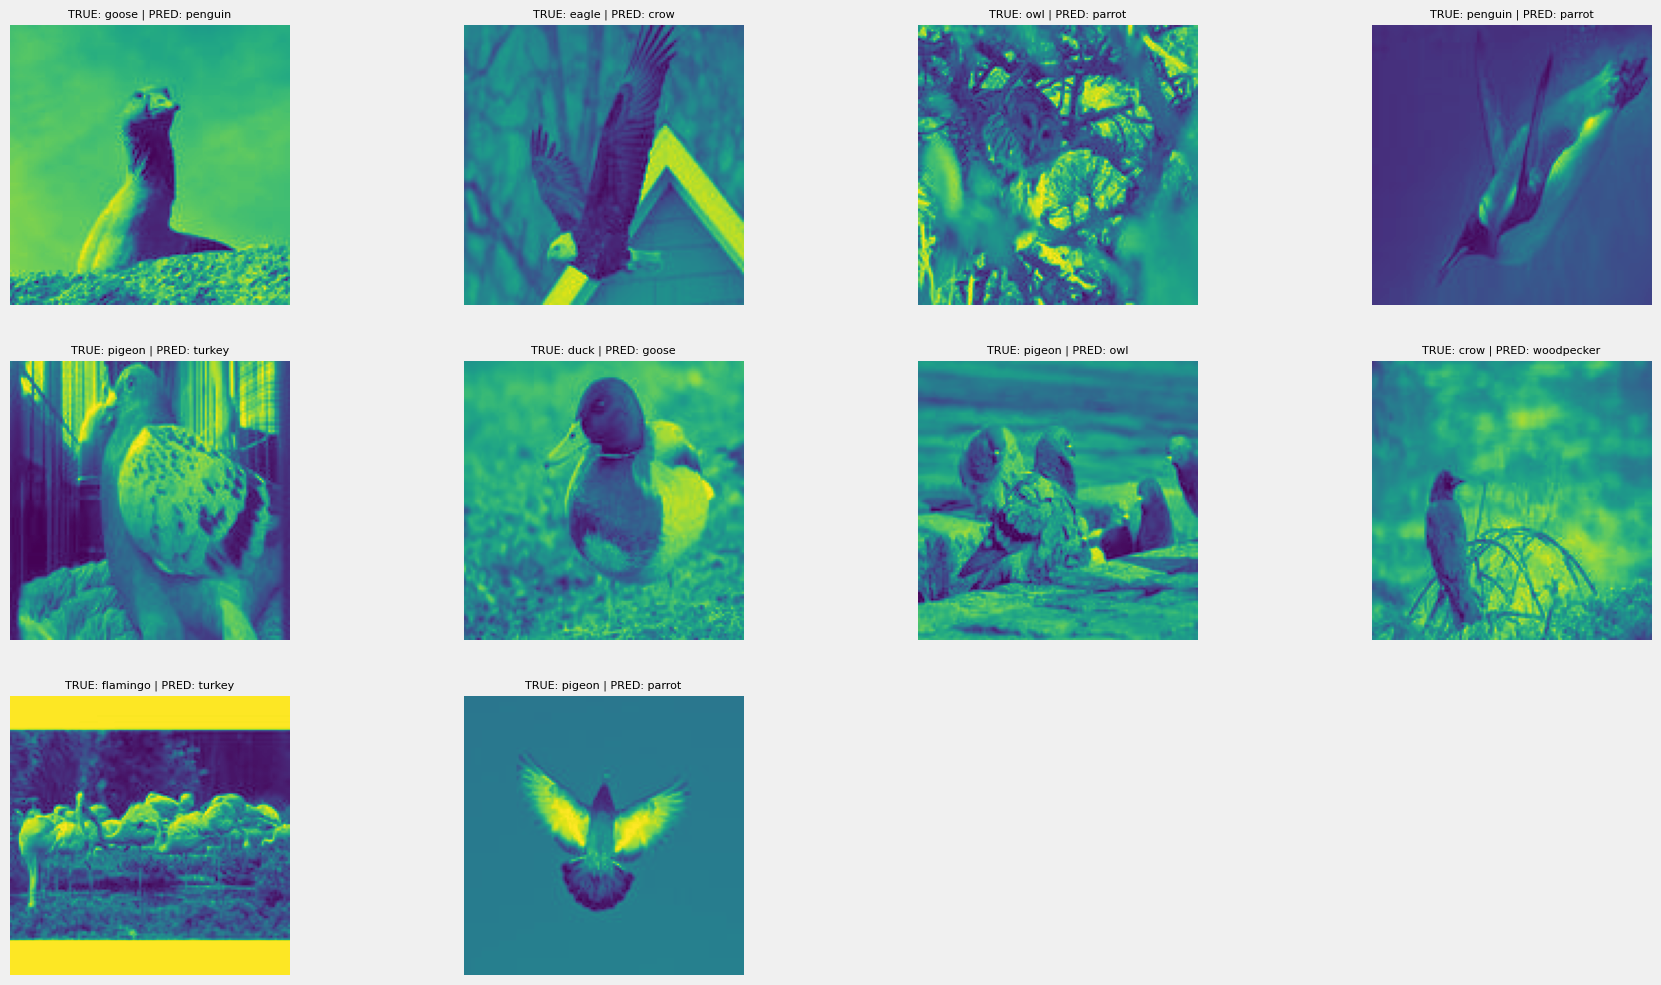

In [69]:
plt.figure(figsize=(20,20))
for i, row in Predictions[Predictions["Test Labels"] != Predictions["Prediction Labels"]].sort_values("Prediction Probability").tail(20).reset_index().iterrows():
    plt.subplot(5,4,i+1)
    image_path = row['Path']
    image = Image.open(image_path)
    plt.imshow(image)
    plt.title(f'TRUE: {row["Test Classes"]} | PRED: {row["Prediction Classes"]}', fontsize=8)
    plt.axis('off')

plt.show()

# Confusion Matrics and Classification Report

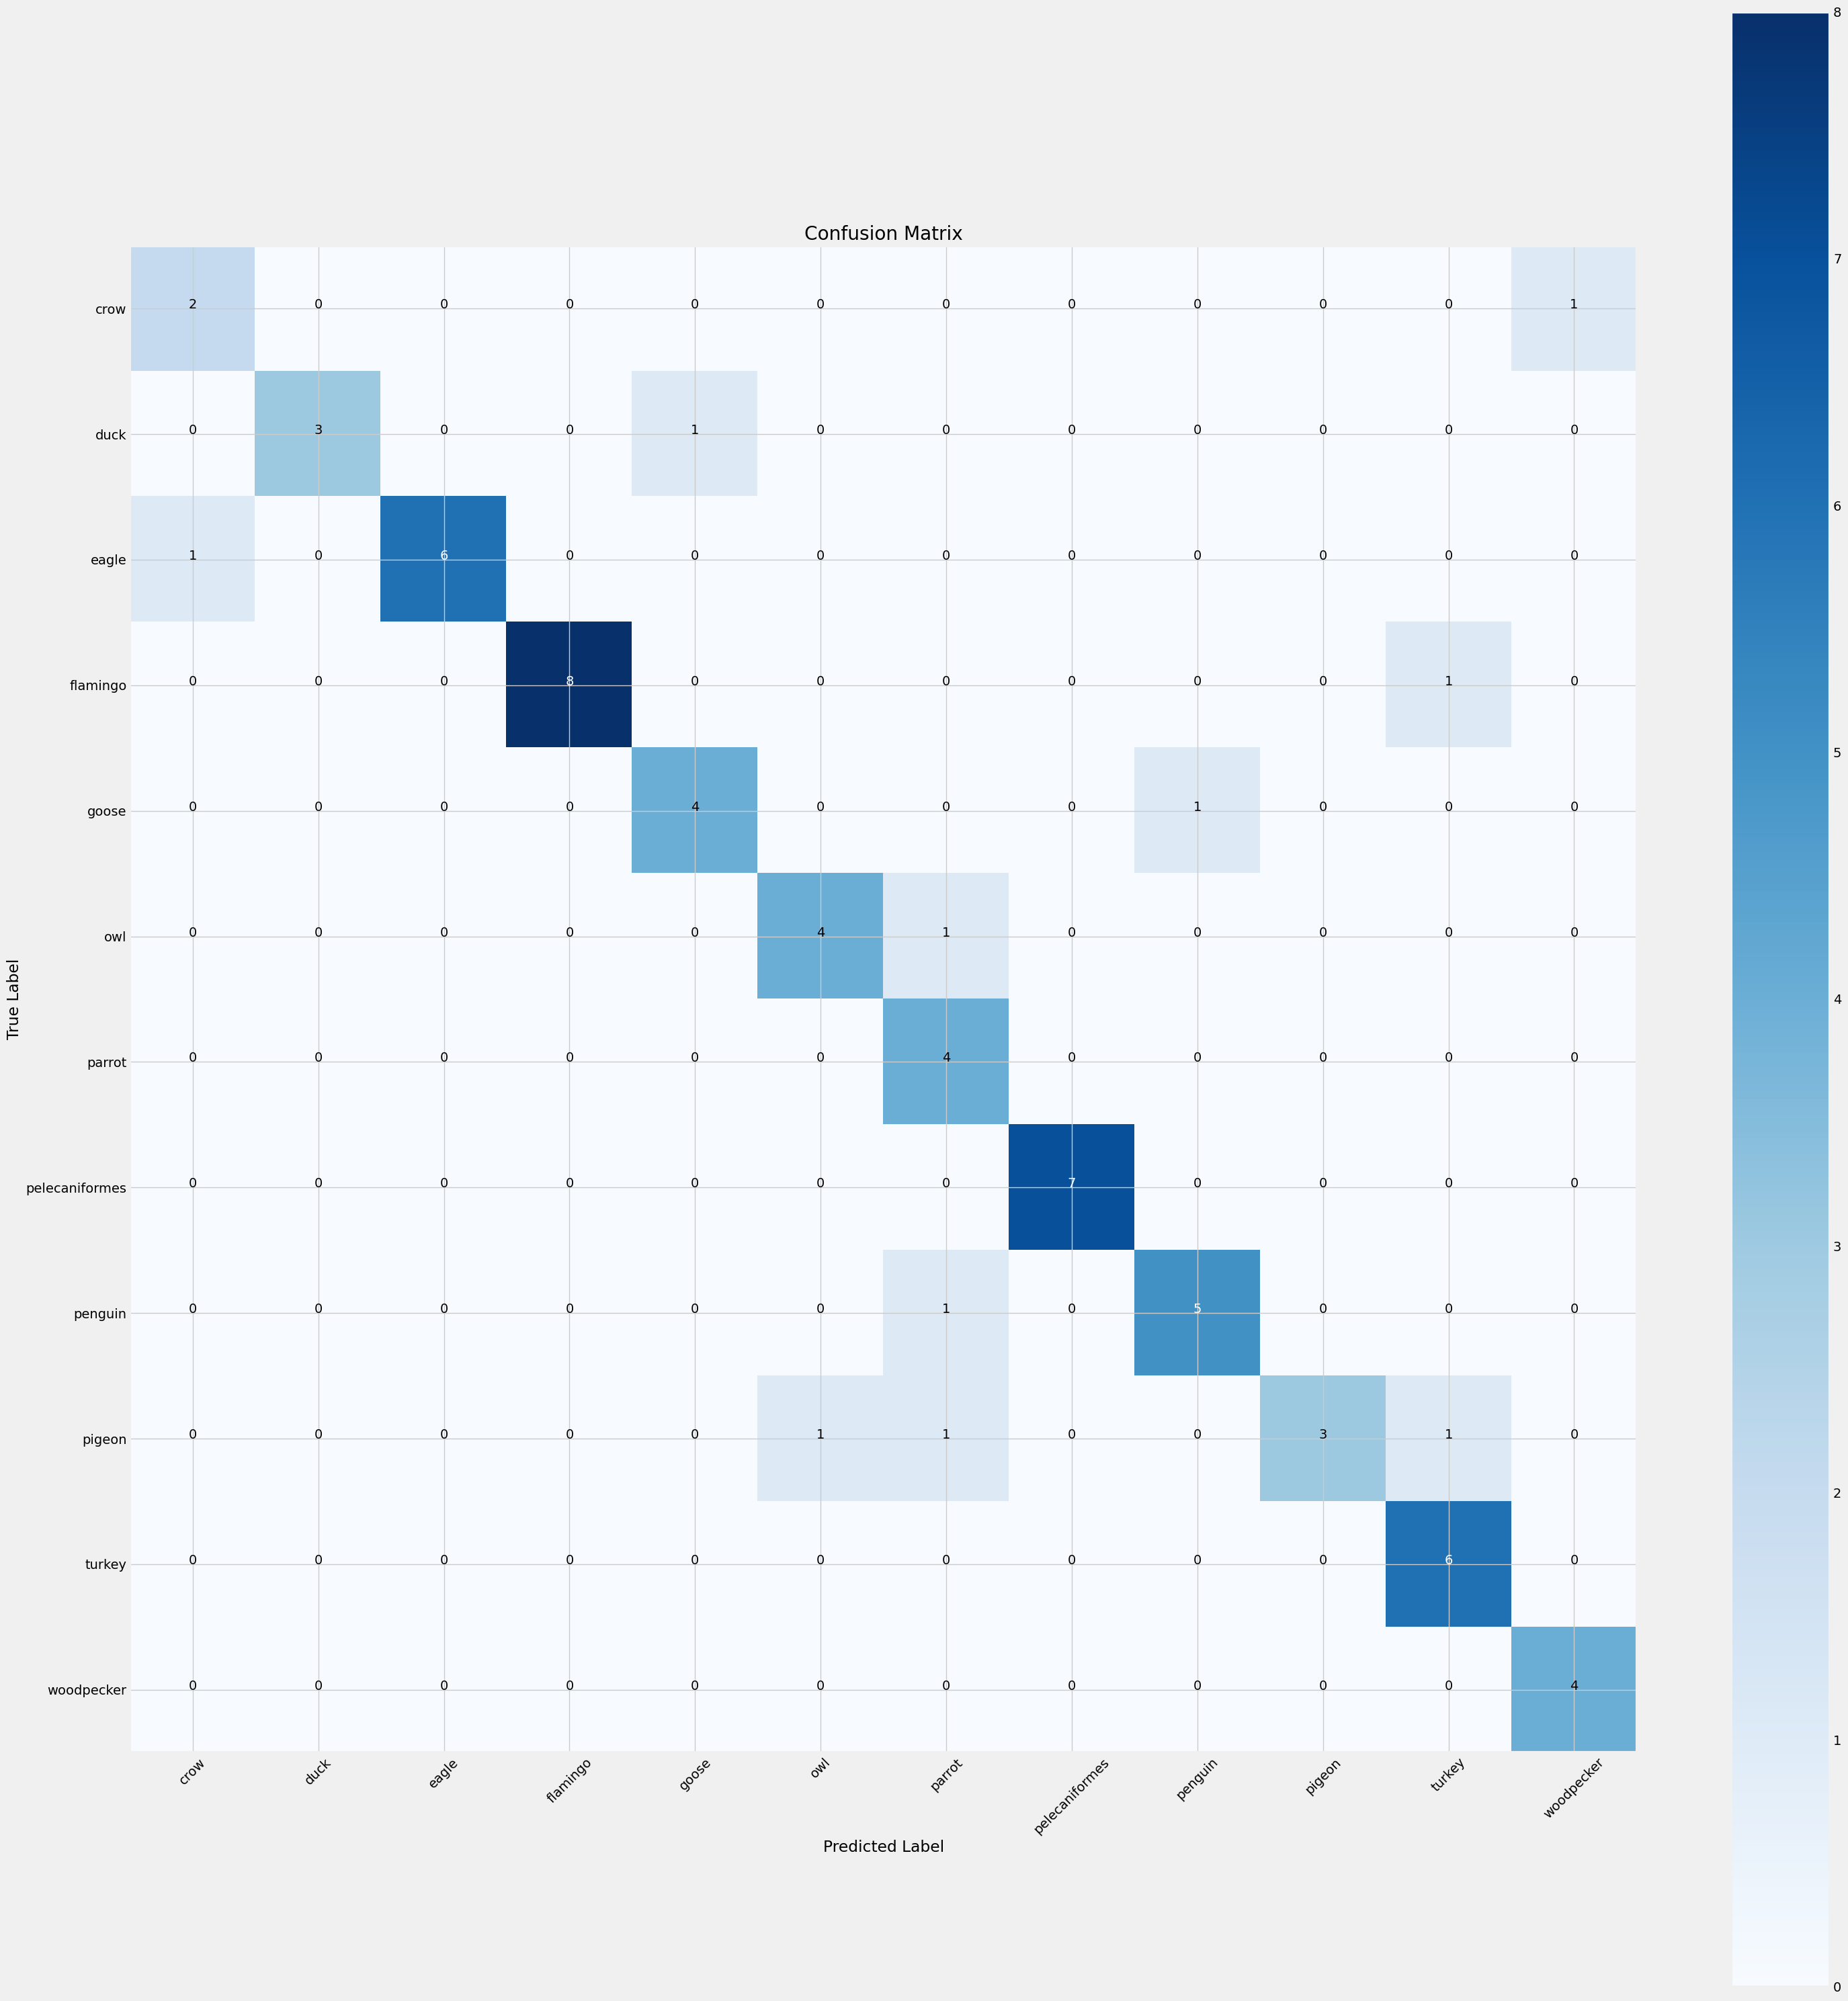

In [67]:
preds = model.predict_generator(test_images)
y_pred = np.argmax(preds, axis=1)
g_dict = test_images.class_indices
classes = list(g_dict.keys())

# Confusion matrix
cm = confusion_matrix(test_images.classes, y_pred)

plt.figure(figsize= (30, 30))
plt.imshow(cm, interpolation= 'nearest', cmap= plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()

tick_marks = np.arange(len(classes))
plt.xticks(tick_marks, classes, rotation= 45)
plt.yticks(tick_marks, classes)


thresh = cm.max() / 2.
for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
    plt.text(j, i, cm[i, j], horizontalalignment= 'center', color= 'white' if cm[i, j] > thresh else 'black')

plt.tight_layout()
plt.ylabel('True Label')
plt.xlabel('Predicted Label')

plt.show()

In [149]:
# Импортируем библиотеку для работы с файлами
from google.colab import files
# Загрузим изображение
file = files.upload()
filename = next(iter(file))
print(filename)

Saving images (2).jfif to images (2).jfif
images (2).jfif


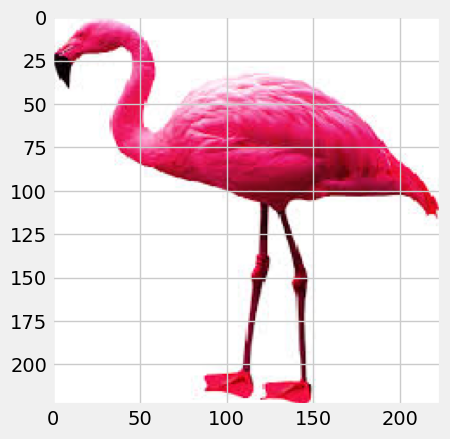

1/1 [==============================] - 2s 2s/step
Predicted: ('n02007558', 'flamingo', 0.696)


In [150]:
from keras.applications.resnet50 import ResNet50, preprocess_input, decode_predictions
from keras.preprocessing import image
import numpy as np
import matplotlib.pyplot as plt

# Load the pre-trained ResNet50 model
model = ResNet50(weights='imagenet')

# File path to your image
img_path = f'/content/{filename}'

# Load the image and resize to the model’s expected input size (224, 224 for ResNet50)
img = image.load_img(img_path, target_size=(224, 224))

# Display the image
plt.imshow(img)
plt.show()

# Convert the image to a numpy array
x = image.img_to_array(img)

# Expand the dimensions to simulate a batch of size 1
x = np.expand_dims(x, axis=0)

# Preprocess the image array
x = preprocess_input(x)

# Make the predictions
preds = model.predict(x)

# Decode the predictions
print('Predicted:', *decode_predictions(preds, top=1)[0])